In [1]:
import numpy as np
import tensorflow as tf
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train_new = X_train.reshape(len(X_train),-1)
X_valid_new = X_valid.reshape(len(X_valid),-1)

In [3]:
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

In [4]:
class_names = ["T-shirt/top",
               "Trouser",
               "Pullover",
               "Dress",
               "Coat",
               "Sandal",
               "Shirt",
               "Sneaker",
               "Bag",
               "Ankle boot"]

In [5]:
pca = PCA(n_components=28,
          random_state=42)
pca.fit(X_train_new)
X_train_new = pca.transform(X_train_new)
X_valid_new = pca.transform(X_valid_new)

In [6]:
kmeans_per_k = [KMeans(n_clusters=k,
                       init="k-means++",
                       max_iter=100,
                       n_init=10,
                       random_state=42)\
                        .fit(X_train_new)
                    for k in range(50, 1000 + 1, 50)]

inertias = [model.inertia_ for model in kmeans_per_k]

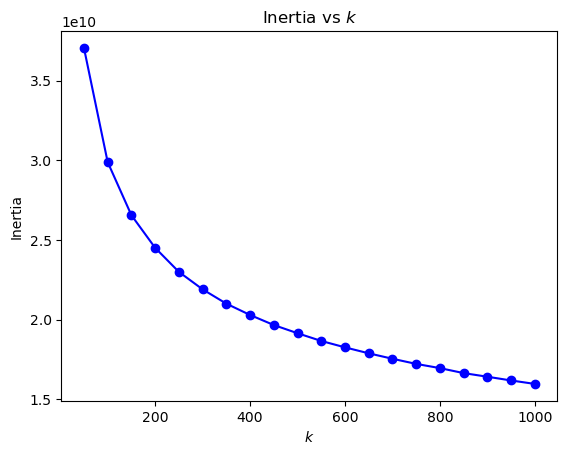

In [7]:
plt.plot([i for i in range(50, 1000 + 1, 50)],
         inertias,
         "bo-")
plt.xlabel("$k$")
plt.ylabel("Inertia")
plt.title("Inertia vs $k$")
plt.show()

In [8]:
k = 450
kmeans = KMeans(n_clusters = k,
                n_init=10,
                init= 'k-means++',
                random_state = 42)
kmeans.fit(X_train_new)
cluster_distance = kmeans.transform(X_train_new)

/Users/sidshah/miniconda3/envs/dmml/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [9]:
km_old_labels = kmeans.labels_
closest = np.argmin(cluster_distance, axis = 0)
labels = np.array([y_train[i] for i in closest])

array([304, 260, 250, ..., 154, 134, 306], dtype=int32)

In [12]:
X_train_ri = np.array([X_train[i] for i in closest])
y_train_ri = np.array([y_train[i] for i in closest])

In [13]:
y_train_fp = np.empty(len(X_train), dtype=np.int32)
for i in range(0,len(X_train)):
   y_train_fp[i] = labels[km_old_labels[i]]

In [14]:
X_distances = cluster_distance[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_distances[in_cluster]
    cutoff = np.percentile(cluster_dist, 20)
    above_cutoff = (X_distances > cutoff)
    X_distances[in_cluster & above_cutoff] = -1

pp = (X_distances != -1)
X_train_pp = X_train[pp]
y_train_pp = y_train_fp[pp]

In [15]:
tf.random.set_seed(42)
model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.InputLayer(shape=[28, 28]))
model1.add(tf.keras.layers.Flatten())
model1.add(tf.keras.layers.Dense(300, activation="relu"))
model1.add(tf.keras.layers.Dense(100, activation="relu"))
model1.add(tf.keras.layers.Dense(10, activation="softmax"))

2024-04-19 21:16:44.163745: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-04-19 21:16:44.163844: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-04-19 21:16:44.163859: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-04-19 21:16:44.164823: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-19 21:16:44.165350: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


ValueError: Unrecognized keyword arguments: ['shape']

In [ ]:
model1.compile(loss="sparse_categorical_crossentropy",
               optimizer="sgd",
               metrics=["accuracy"])

In [ ]:
history = model1.fit(X_train,
                     y_train,
                     epochs=30,
                     validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6817 - loss: 1.0054 - val_accuracy: 0.8324 - val_loss: 0.5012
Epoch 2/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8272 - loss: 0.5023 - val_accuracy: 0.8436 - val_loss: 0.4539
Epoch 3/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8442 - loss: 0.4504 - val_accuracy: 0.8476 - val_loss: 0.4316
Epoch 4/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8535 - loss: 0.4206 - val_accuracy: 0.8508 - val_loss: 0.4161
Epoch 5/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8600 - loss: 0.3988 - val_accuracy: 0.8540 - val_loss: 0.4037
Epoch 6/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8658 - loss: 0.3812 - val_accuracy: 0.8578 - val_loss: 0.3930
Epoch 7/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8716 - loss: 0.3665 - val_accuracy: 0.8596 - val_loss: 0.3859
Epoch 8/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8750 - loss: 0.3538 - 

In [ ]:
tf.random.set_seed(42)
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.InputLayer(shape=[28, 28]))
model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.Dense(300, activation="relu"))
model2.add(tf.keras.layers.Dense(100, activation="relu"))
model2.add(tf.keras.layers.Dense(10, activation="softmax"))

In [ ]:
model2.compile(loss="sparse_categorical_crossentropy",
               optimizer="sgd",
               metrics=["accuracy"])

In [ ]:
history = model2.fit(X_train_ri, y_train_ri, epochs=30,validation_data=(X_valid, y_valid))

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.2201 - loss: 2.1752 - val_accuracy: 0.3058 - val_loss: 2.0086
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3819 - loss: 1.8706 - val_accuracy: 0.4102 - val_loss: 1.8193
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5257 - loss: 1.6685 - val_accuracy: 0.5034 - val_loss: 1.6546
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5906 - loss: 1.5032 - val_accuracy: 0.5884 - val_loss: 1.5156
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6507 - loss: 1.3683 - val_accuracy: 0.6192 - val_loss: 1.4006
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6749 - loss: 1.2572 - val_accuracy: 0.6352 - val_loss: 1.3050
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6861 - loss: 1.1665 - val_accuracy: 0.6458 - val_loss: 1.2265
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6922 - loss: 1.0899 - val_accuracy: 0.6528 - v

In [ ]:
tf.random.set_seed(42)
model3 = tf.keras.Sequential()
model3.add(tf.keras.layers.InputLayer(shape=[28, 28]))
model3.add(tf.keras.layers.Flatten())
model3.add(tf.keras.layers.Dense(300, activation="relu"))
model3.add(tf.keras.layers.Dense(100, activation="relu"))
model3.add(tf.keras.layers.Dense(10, activation="softmax"))

In [ ]:
model3.compile(loss="sparse_categorical_crossentropy",optimizer="sgd",metrics=["accuracy"])

In [ ]:
history = model3.fit(X_train, y_train_fp, epochs=30,validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6907 - loss: 0.9512 - val_accuracy: 0.7810 - val_loss: 0.6302
Epoch 2/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8049 - loss: 0.5142 - val_accuracy: 0.7838 - val_loss: 0.6025
Epoch 3/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8168 - loss: 0.4740 - val_accuracy: 0.7894 - val_loss: 0.5887
Epoch 4/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8241 - loss: 0.4494 - val_accuracy: 0.7914 - val_loss: 0.5807
Epoch 5/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8285 - loss: 0.4310 - val_accuracy: 0.7928 - val_loss: 0.5754
Epoch 6/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8339 - loss: 0.4158 - val_accuracy: 0.7950 - val_loss: 0.5754
Epoch 7/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8384 - loss: 0.4029 - val_accuracy: 0.7972 - val_loss: 0.5776
Epoch 8/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8417 - loss: 0.3918 - 

In [ ]:
tf.random.set_seed(42)
model4 = tf.keras.Sequential()
model4.add(tf.keras.layers.InputLayer(shape=[28, 28]))
model4.add(tf.keras.layers.Flatten())
model4.add(tf.keras.layers.Dense(300, activation="relu"))
model4.add(tf.keras.layers.Dense(100, activation="relu"))
model4.add(tf.keras.layers.Dense(10, activation="softmax"))

In [ ]:
model4.compile(loss="sparse_categorical_crossentropy",optimizer="sgd",metrics=["accuracy"])

In [ ]:
history = model4.fit(X_train_pp, y_train_pp, epochs=30,validation_data=(X_valid, y_valid))

Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5546 - loss: 1.4610 - val_accuracy: 0.7376 - val_loss: 0.7613
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7831 - loss: 0.6395 - val_accuracy: 0.7730 - val_loss: 0.6555
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8238 - loss: 0.5222 - val_accuracy: 0.7824 - val_loss: 0.6184
Epoch 4/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8378 - loss: 0.4678 - val_accuracy: 0.7874 - val_loss: 0.6013
Epoch 5/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8445 - loss: 0.4362 - val_accuracy: 0.7888 - val_loss: 0.5930
Epoch 6/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8488 - loss: 0.4149 - val_accuracy: 0.7898 - val_loss: 0.5899
Epoch 7/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8539 - loss: 0.3990 - val_accuracy: 0.7914 - val_loss: 0.5888
Epoch 8/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8579 - loss: 0.3864 - val_accuracy: 0.